In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
sns.set_theme()
sns.set_style('whitegrid')

def get_raw_results(cur_dir, skip=0, till=-1):
    with open(cur_dir, 'r') as file:
        elems = file.read().split('\n')[skip:till]
        elems = [float(e) for e in elems]
        return elems

def results_generator(l, basedir, skip=0, till=-1):
    for d in l:
        cur_dir = os.path.join(basedir, d)
        elems = get_raw_results(cur_dir, skip, till)
        m = sum(elems) / len(elems)
        yield m

In [24]:
def make_read_write_graph(ax, basedir, title, scalability=False):
    numerical = [int(dir) for dir in os.listdir(basedir + '/mmio')]
    numerical.sort()
    l = [str(dir) for dir in numerical]

    results1 = list(results_generator(l, basedir + '/ddr', skip=1))
    results2 = list(results_generator(l, basedir + '/hbm', skip=1))
    results3 = list(results_generator(l, basedir + '/mmio', skip=0, till=1))

    #plt.figure(figsize=(6,4))
    if not scalability:
        ax.set_xscale('log', base=2)
    #ax.yscale('log', base=10)
    ax.set_title(title)
    if scalability:
        ax.set_xlabel('Num threads/blocks')
    else:
        ax.set_xlabel('Buffer Size (bytes)')
    ax.set_ylabel('Throughput (GB/s)')
    ax.plot(numerical, results1, 'o', label='DDR')
    ax.plot(numerical, results2, 'x', label='HBM')
    ax.plot(numerical, results3, '.', label='MMIO')
    if not scalability:
        ax.axvline(x=65536, ls=':', label = 'CPU L1')
        ax.axvline(x=1048576, ls='-.', label = 'CPU L2')
        ax.axvline(x=119537664, ls='--', label = 'CPU L3')
        ax.axvline(x=262144, ls=':', color='red', label = 'GPU L1')
        ax.axvline(x=52428800, ls='-.', color='red', label = 'GPU L2')
    ax.legend(title='Memory type')

def make_copy_graph(ax, basedir, title, scalability=False):
    numerical = [int(dir) for dir in os.listdir(basedir + '/hbm_ddr')]
    numerical.sort()
    numerical = numerical[::]
    l = [str(dir) for dir in numerical]

    results1 = list(results_generator(l, basedir + '/ddr_ddr', skip=1))
    results2 = list(results_generator(l, basedir + '/hbm_hbm', skip=1))
    results3 = list(results_generator(l, basedir + '/hbm_ddr', skip=1))
    results4 = list(results_generator(l, basedir + '/ddr_hbm', skip=1))

    #plt.figure(figsize=(6,4))
    if not scalability:
        ax.set_xscale('log', base=2)
    #ax.yscale('log', base=10)
    ax.set_title(title)
    if scalability:
        ax.set_xlabel('Num threads/blocks')
    else:
        ax.set_xlabel('Buffer Size (bytes)')
    ax.set_ylabel('Throughput (GB/s)')
    ax.plot(numerical, results1, 'o', label='DDR->DDR')
    ax.plot(numerical, results2, 'x', label='HBM->HBM')
    ax.plot(numerical, results3, 's', label='HBM->DDR')
    ax.plot(numerical, results4, '^', label='DDR->HBM')
    if not scalability:
        ax.axvline(x=65536, ls=':', label = 'CPU L1')
        ax.axvline(x=1048576, ls='-.', label = 'CPU L2')
        ax.axvline(x=119537664, ls='--', label = 'CPU L3')
        ax.axvline(x=262144, ls=':', color='red', label = 'GPU L1')
        ax.axvline(x=52428800, ls='-.', color='red', label = 'GPU L2')
    ax.legend(title='Memory type')

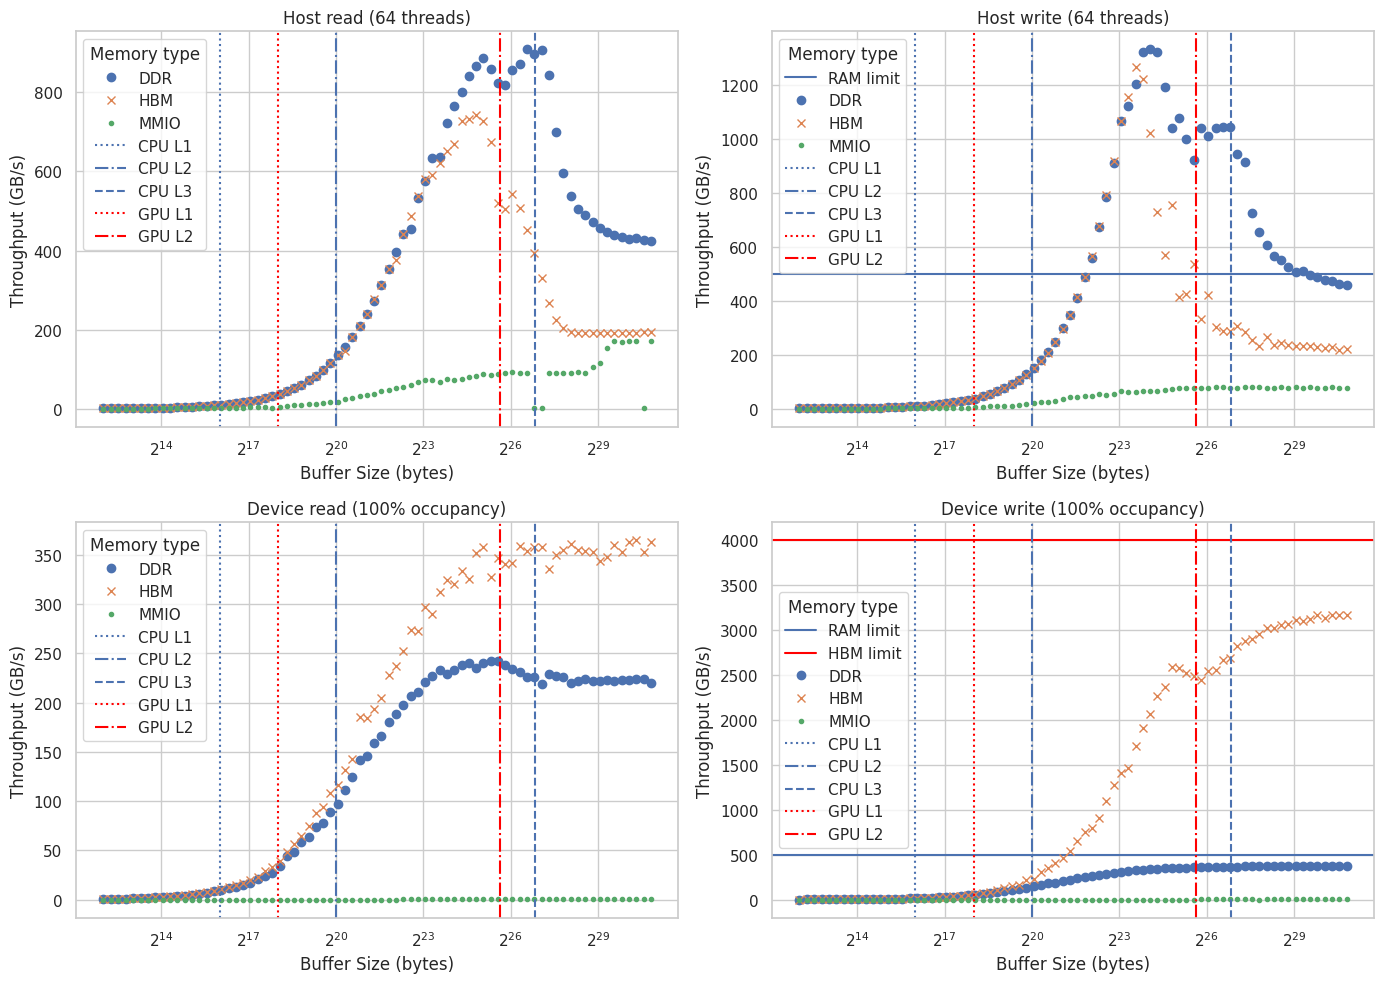

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,10))
make_read_write_graph(ax1, 'results/read/host', 'Host read (64 threads)')
ax2.axhline(y=500, label='RAM limit')
make_read_write_graph(ax2, 'results/write/host', 'Host write (64 threads)')
make_read_write_graph(ax3, 'results/read/device', 'Device read (100% occupancy)')
ax4.axhline(y=500, label='RAM limit')
ax4.axhline(y=4000, color='red', label='HBM limit')
make_read_write_graph(ax4, 'results/write/device', 'Device write (100% occupancy)')
plt.tight_layout()

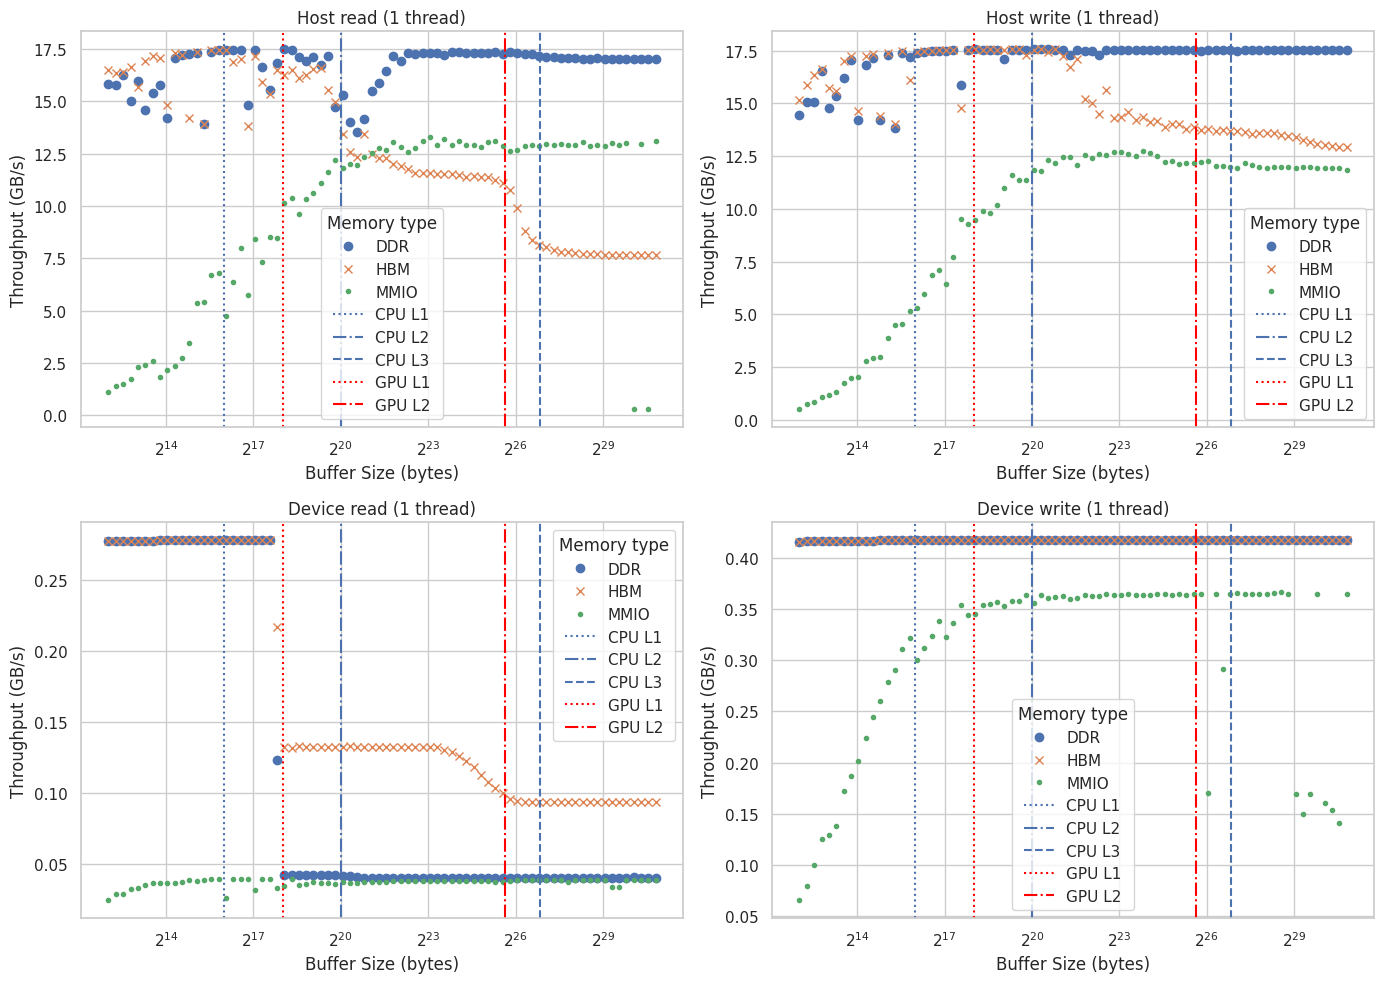

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,10))
make_read_write_graph(ax1, 'results/read/host/single', 'Host read (1 thread)')
make_read_write_graph(ax2, 'results/write/host/single', 'Host write (1 thread)')
make_read_write_graph(ax3, 'results/read/device/single', 'Device read (1 thread)')
make_read_write_graph(ax4, 'results/write/device/single', 'Device write (1 thread)')
plt.tight_layout()

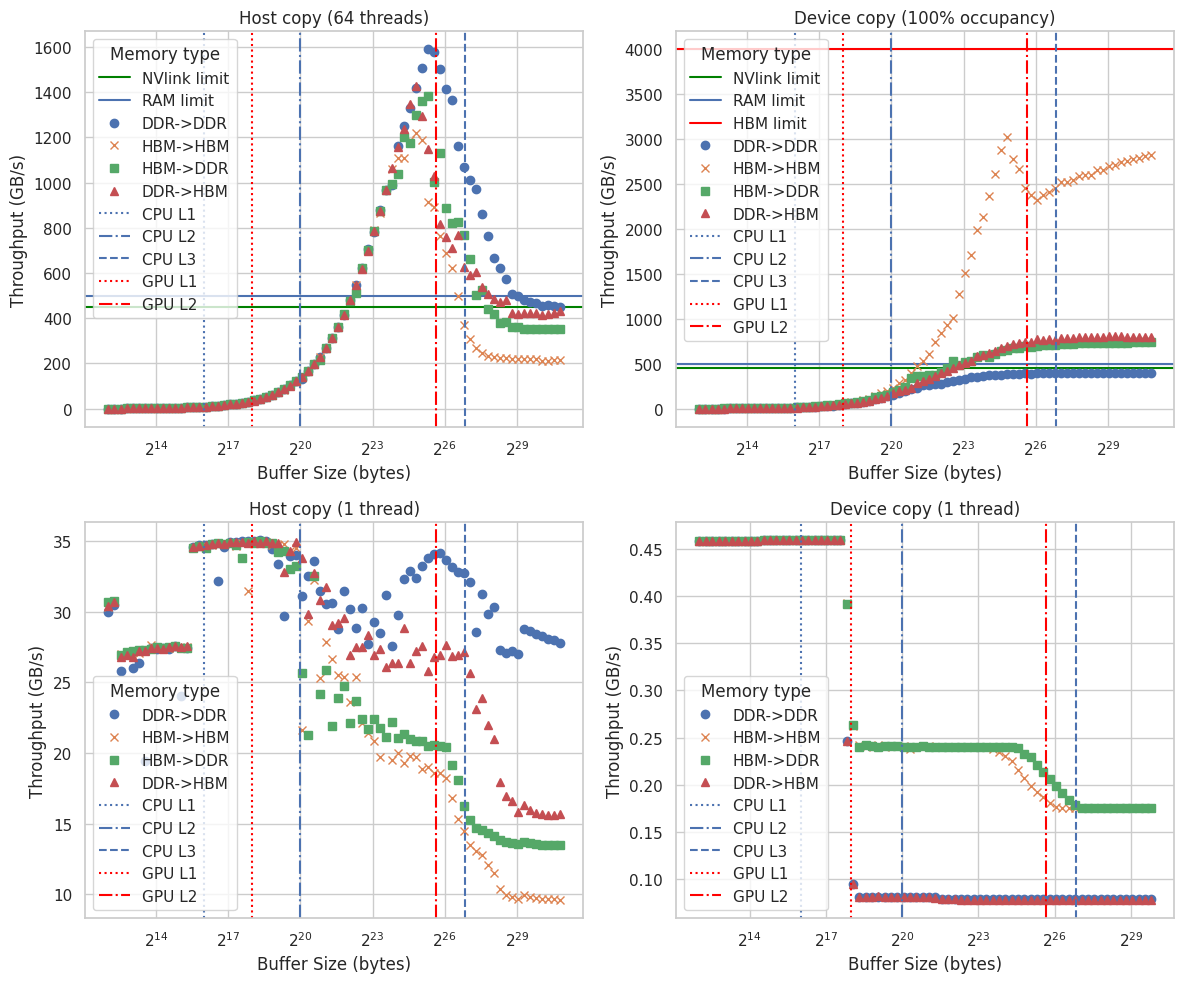

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,10))
ax1.axhline(y=450, color='green', label='NVlink limit')
ax1.axhline(y=500, label='RAM limit')
make_copy_graph(ax1, 'results/copy/host', 'Host copy (64 threads)')
ax2.axhline(y=450, color='green', label='NVlink limit')
ax2.axhline(y=500, label='RAM limit')
ax2.axhline(y=4000, color='red', label='HBM limit')
make_copy_graph(ax2, 'results/copy/device', 'Device copy (100% occupancy)')
make_copy_graph(ax3, 'results/copy/host/single', 'Host copy (1 thread)')
make_copy_graph(ax4, 'results/copy/device/single', 'Device copy (1 thread)')
plt.tight_layout()

<Axes: title={'center': 'Cacheline-level ptr chase (524 288 hops, 1000 times)'}, ylabel='latency (us)'>

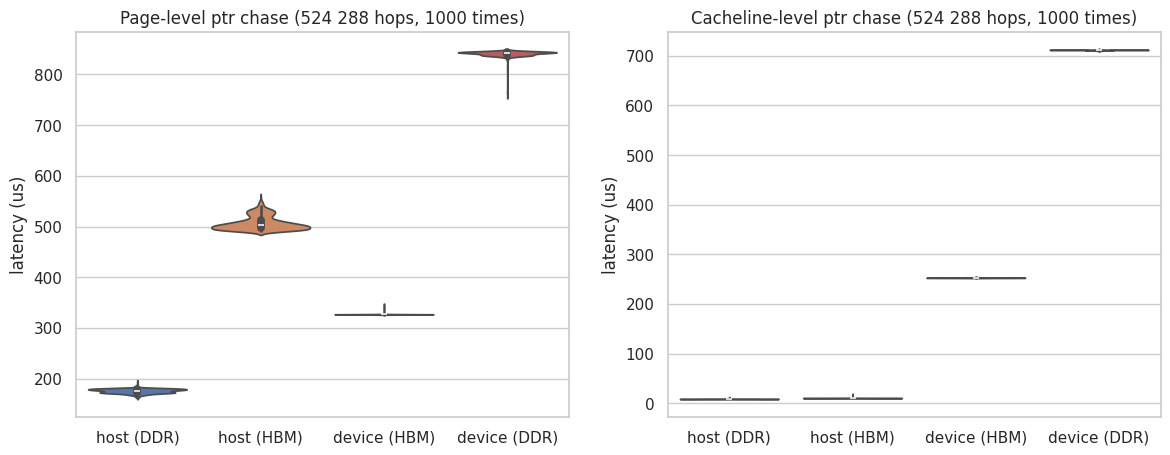

In [29]:
experiments1 = ['host/ddr', 'host/hbm', 'device/hbm', 'device/ddr']
experiments2 = ['fine/host/ddr', 'fine/host/hbm', 'fine/device/hbm', 'fine/device/ddr']
labels = ['host (DDR)', 'host (HBM)', 'device (HBM)', 'device (DDR)']
data1 = {}
data2 = {}

for e, l in zip(experiments1, labels):
    with open('results/latency/' + e, 'r') as file:
        elems = file.read().split('\n')[1:-1]
        elems = [float(e) for e in elems]
        data1[l] = elems

for e, l in zip(experiments2, labels):
    with open('results/latency/' + e, 'r') as file:
        elems = file.read().split('\n')[1:-1]
        elems = [float(e) for e in elems]
        data2[l] = elems

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.set_title('Page-level ptr chase (524 288 hops, 1000 times)')
ax2.set_title('Cacheline-level ptr chase (524 288 hops, 1000 times)')
ax1.set_ylabel('latency (us)')
ax2.set_ylabel('latency (us)')
sns.violinplot(data1, ax=ax1)
sns.violinplot(data2, ax=ax2)

# ax3 = fig.add_axes([.58, .5, .2, .3])
# experiments = ['fine/host/ddr', 'fine/host/hbm']
# labels = ['host (DDR)', 'host (HBM)']
# data = {}

# for e, l in zip(experiments, labels):
#     with open('results/latency/' + e, 'r') as file:
#         elems = file.read().split('\n')[1:-1]
#         elems = [float(e) for e in elems]
#         data[l] = elems
# ax = sns.violinplot(data, ax=ax3)

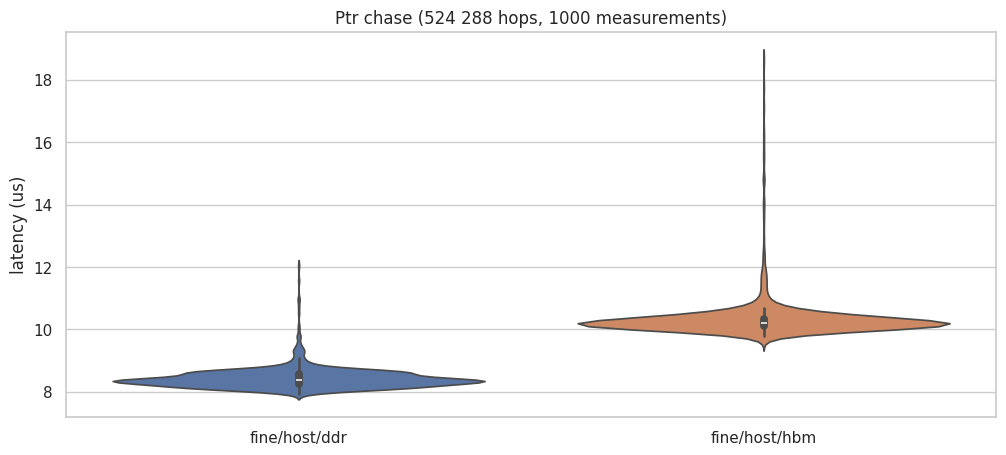

In [15]:
experiments = ['fine/host/ddr', 'fine/host/hbm']
data = {}

for e in experiments:
    with open('results/latency/' + e, 'r') as file:
        elems = file.read().split('\n')[1:-1]
        elems = [float(e) for e in elems]
        data[e] = elems

plt.figure(figsize=(12, 5))
plt.title('Ptr chase (524 288 hops, 1000 measurements)')
plt.ylabel('latency (us)')
ax = sns.violinplot(data)

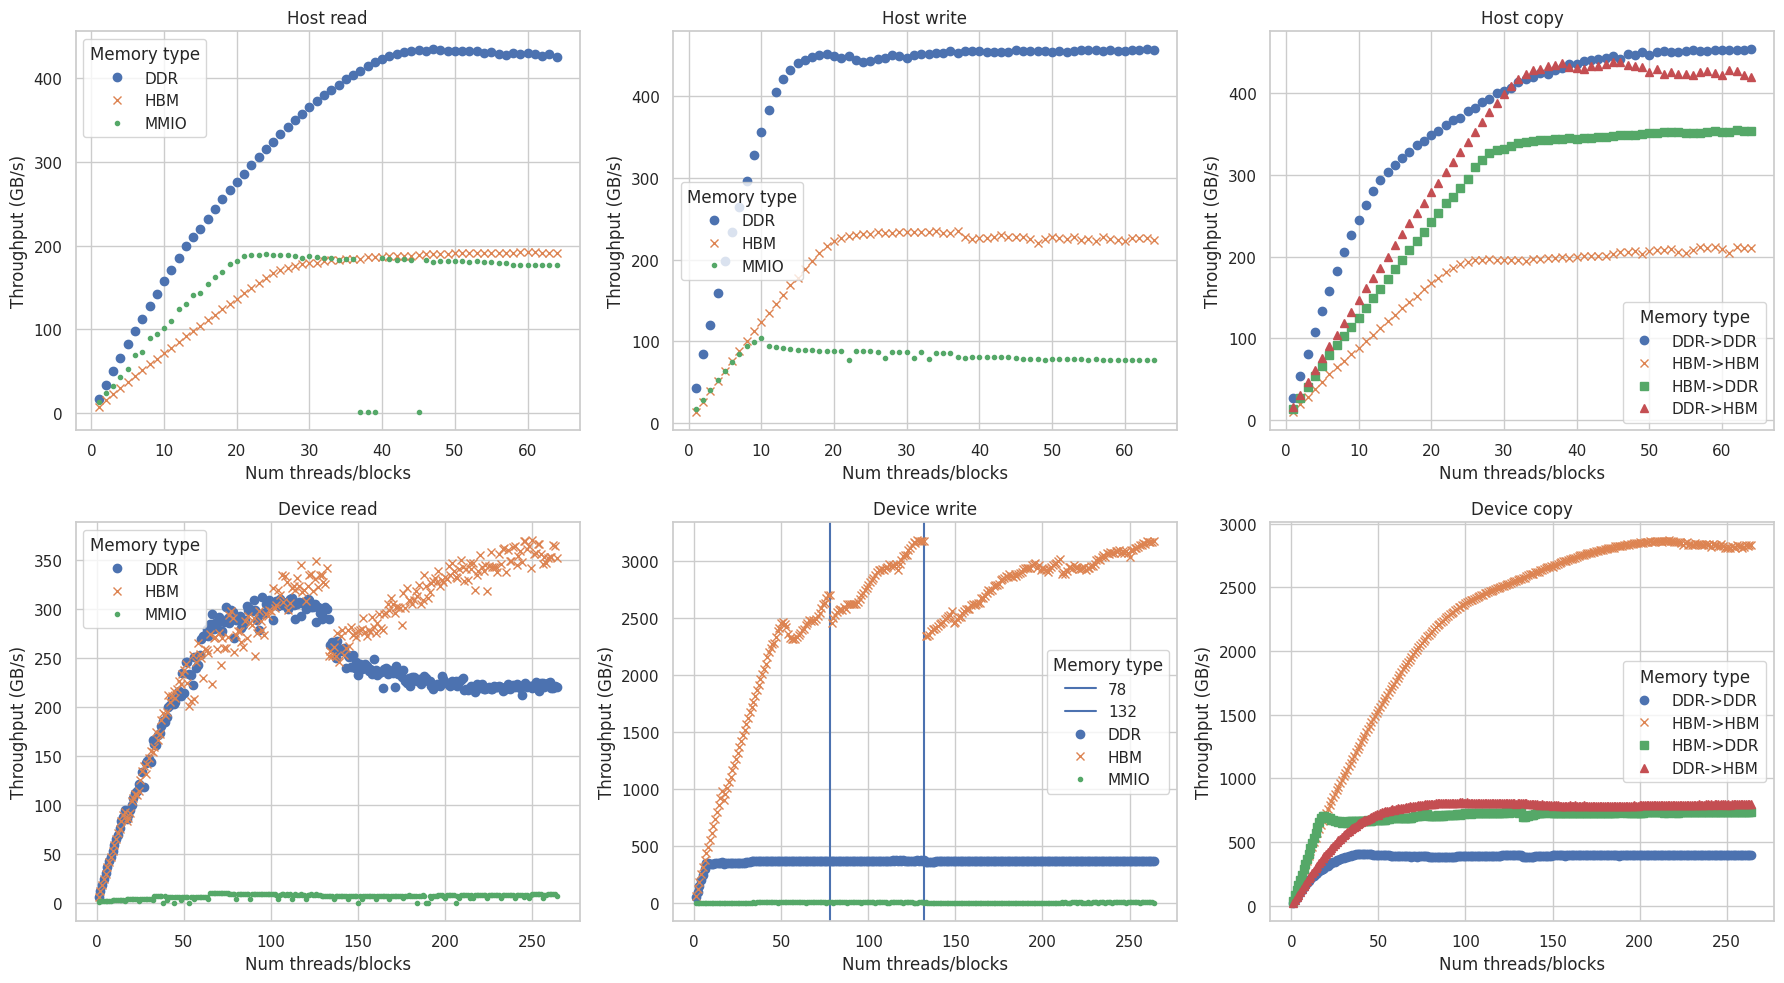

In [28]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18,10))
make_read_write_graph(ax1, 'results/read/host/scalability', 'Host read', True)
make_read_write_graph(ax2, 'results/write/host/scalability', 'Host write', True)
make_copy_graph(ax3, 'results/copy/host/scalability', 'Host copy', True)
make_read_write_graph(ax4, 'results/read/device/scalability', 'Device read', True)
ax5.axvline(x=78, label=78)
ax5.axvline(x=132, label=132)
make_read_write_graph(ax5, 'results/write/device/scalability', 'Device write', True)
make_copy_graph(ax6, 'results/copy/device/scalability', 'Device copy', True)
plt.tight_layout()